# Homework 2
### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [248]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json

### Question 1

Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.


In [249]:
URL1 = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
URL2 = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'

In [250]:
# Do the request
r = requests.get(URL1)

Inspecting the DOM of the website, we find that the ranking datas are stored in a text file at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt as we can see here :

In [251]:
# 357051.txt
id1 = r.text.find("357051.txt")
r.text[id1-88:id1+11]

'"rank_url":"https:\\/\\/www.topuniversities.com\\/sites\\/default\\/files\\/qs-rankings-data\\/357051.txt"'

We thus request the datas from this URL, keeping only the 200 first elements.

In [252]:
data_QS_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
data_QS = requests.get(data_QS_URL)
#create the dataframe
df_QS = pd.DataFrame(data_QS.json()['data'][:200])

We now keep the relevant columns.

In [253]:
# select only the useful columns
df_ranking = pd.DataFrame({"University" : df_QS.title,\
                           "Rank" : df_QS.rank_display,\
                           "Score" : df_QS.score,\
                           "Country": df_QS.country,\
                           "Region": df_QS.region, "URL" : df_QS.url},\
                          columns = ['Rank', 'University', 'Score', 'Country', 'Region', 'URL'])

In [254]:
df_ranking

,Rank,University,Score,Country,Region,URL
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,/universities/massachusetts-institute-technolo...
1,2,Stanford University,98.7,United States,North America,/universities/stanford-university
2,3,Harvard University,98.4,United States,North America,/universities/harvard-university
3,4,California Institute of Technology (Caltech),97.7,United States,North America,/universities/california-institute-technology-...
4,5,University of Cambridge,95.6,United Kingdom,Europe,/universities/university-cambridge
5,6,University of Oxford,95.3,United Kingdom,Europe,/universities/university-oxford
6,7,UCL (University College London),94.6,United Kingdom,Europe,/universities/ucl-university-college-london
7,8,Imperial College London,93.7,United Kingdom,Europe,/universities/imperial-college-london
8,9,University of Chicago,93.5,United States,North America,/universities/university-chicago
9,10,ETH Zurich - Swiss Federal Institute of Techno...,93.3,Switzerland,Europe,/universities/eth-zurich-swiss-federal-institu...


We observe that the 200th university has a rank = 201, this is because there is no 198th (we can see that the last 195th should be the 197th, and the next rank is 199).

We now have to get the number of faculties and students for each university. For this, we have to go the page of the university on the topuniversities website, and collect these information. Inspecting these webapges, we find that the number of faculty members is in the div number of the div total faculty, the number of international faculty members is in the div number of the div inter faculty, the number of students is in the div number of the div total students, and finally the number of international students is in the div number of the div total inter.

In [255]:
# fetch the university informations from its webpage
def get_numbers_of(url):
    # get the data from the university page
    r = requests.get('https://www.topuniversities.com'+url)
    soup = BeautifulSoup(r.text, "html.parser")
    # find the corresponding tag
    try:
        staff = soup.find('div', class_="total faculty").find('div', class_="number").string
        staff = int(str(staff).replace('\n', "").replace(",", ""))
    except:
        staff = np.nan
    try :
        inter_staff = soup.find('div', class_="inter faculty").find('div', class_="number").string
        inter_staff = int(str(inter_staff).replace('\n', "").replace(",", ""))
    except:
        inter_staff = np.nan
    try : 
        students = soup.find('div', class_="total student").find('div', class_="number").string
        students = int(str(students).replace('\n', "").replace(",", ""))
    except:
        students = np.nan
    try : 
        inter_students = soup.find('div', class_="total inter").find('div', class_="number").string
        inter_students = int(str(inter_students).replace('\n', "").replace(",", ""))
    except:
        inter_students = np.nan
    
    return staff, inter_staff, students, inter_students

We fetch the results into new columns in our dataframe.

In [256]:
df_ranking['Total Faculty Members'], \
df_ranking['International Faculty Members'], \
df_ranking['Total Students'], \
df_ranking['International Students'] = zip(*df_ranking['URL'].map(get_numbers_of))

We can now remove the URL columns, as it is not useful anymore.

In [257]:
df_ranking = df_ranking.drop('URL', axis=1)
df_ranking

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,2982.0,1679.0,11067.0,3717.0
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0
2,3,Harvard University,98.4,United States,North America,4350.0,1311.0,22429.0,5266.0
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0
5,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0
6,7,UCL (University College London),94.6,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0
7,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0
8,9,University of Chicago,93.5,United States,North America,2449.0,635.0,13557.0,3379.0
9,10,ETH Zurich - Swiss Federal Institute of Techno...,93.3,Switzerland,Europe,2477.0,1886.0,19815.0,7563.0


#### a) Which are the best universities in term of ratio between faculty members and students ?

In [258]:
df_ranking['% Fac Members'] = df_ranking['Total Faculty Members']/(df_ranking['Total Faculty Members']+df_ranking['Total Students'])*100

In [259]:
df_ranking.sort_values('% Fac Members', ascending=False)

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students,% Fac Members
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0,29.706983
15,16,Yale University,90.4,United States,North America,4940.0,1708.0,12402.0,2469.0,28.485757
5,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,25.500567
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,22.629843
16,17,Johns Hopkins University,89.8,United States,North America,4462.0,1061.0,16146.0,4105.0,21.651786
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0,21.251798
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,2982.0,1679.0,11067.0,3717.0,21.225710
185,186,University of Rochester,49.3,United States,North America,2569.0,488.0,9636.0,2805.0,21.048751
18,19,University of Pennsylvania,88.7,United States,North America,5499.0,1383.0,20639.0,4250.0,21.038335
17,18,Columbia University,88.9,United States,North America,6189.0,913.0,25045.0,8105.0,19.814945


In [260]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

def bars(t, data, xlab, ylab):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,8))
    ax.set_title(t, fontsize=15, fontweight='bold')
    sns.barplot(x=xlab, y=ylab, data=data, saturation=0.7, errcolor='.7')
    plt.xticks(rotation=90)
    plt.show()

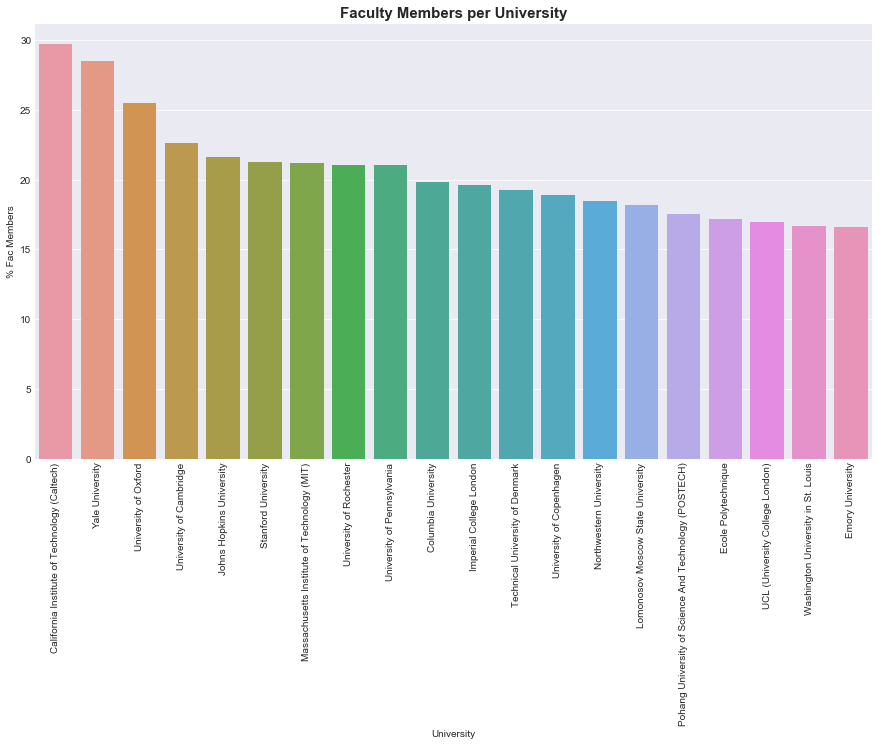

In [261]:
bars("Faculty Members per University", df_ranking.sort_values('% Fac Members', ascending=False)[:20], 'University', '% Fac Members')

We observe that this ranking is different from the original ranking, but the 10 first university are almost all in the top 20 of the initial ranking.

#### b) Which are the best universities in term of ratio of international students?

In [262]:
df_ranking['% International Students'] = df_ranking['International Students']/df_ranking['Total Students']*100

In [263]:
df_ranking.sort_values('% International Students', ascending=False)

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students,% Fac Members,% International Students
34,35,London School of Economics and Political Scien...,81.8,United Kingdom,Europe,1088.0,687.0,9760.0,6748.0,10.029499,69.139344
11,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),91.2,Switzerland,Europe,1695.0,1300.0,10343.0,5896.0,14.080412,57.004738
7,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,19.630370,54.356743
198,200,Maastricht University,47.9,Netherlands,Europe,1277.0,502.0,16385.0,8234.0,7.230212,50.253280
47,=47,Carnegie Mellon University,78.6,United States,North America,1342.0,425.0,13356.0,6385.0,9.130494,47.806229
6,7,UCL (University College London),94.6,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0,16.953908,47.792793
91,92,University of St Andrews,65.3,United Kingdom,Europe,1140.0,485.0,8800.0,4030.0,11.468813,45.795455
41,=41,The University of Melbourne,80.4,Australia,Oceania,3311.0,1477.0,42182.0,18030.0,7.278043,42.743350
126,127,Queen Mary University of London,58.3,United Kingdom,Europe,1885.0,801.0,16135.0,6806.0,10.460599,42.181593
25,26,The University of Hong Kong,85.5,Hong Kong,Asia,3012.0,2085.0,20214.0,8230.0,12.968225,40.714356


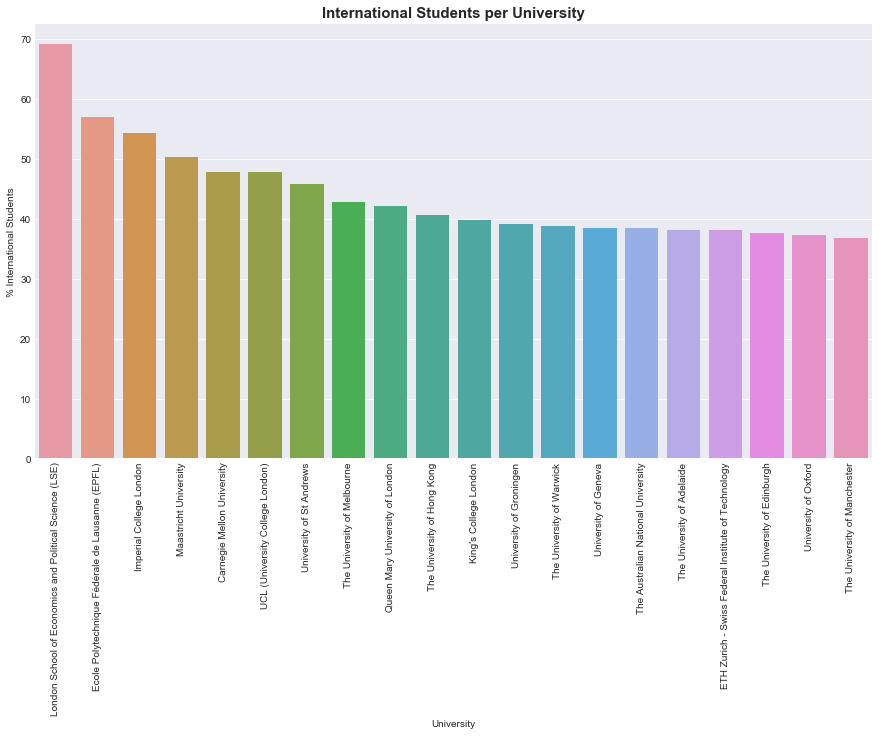

In [264]:
bars("International Students per University", df_ranking.sort_values('% International Students', ascending=False)[:20], 'University', '% International Students')

Here, the results are completely different from the original ranking.

#### c) Aggregating the data by country

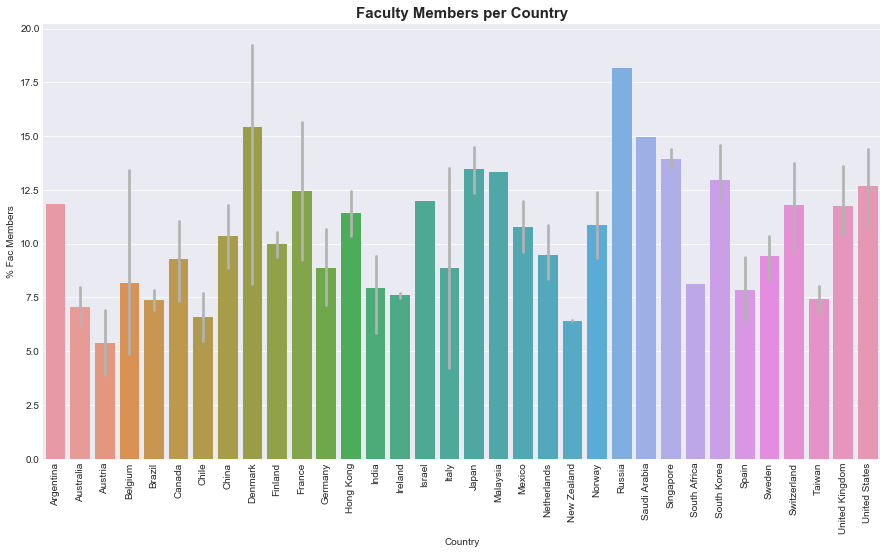

In [265]:
bars("Faculty Members per Country", df_ranking.sort_values('Country'), 'Country', '% Fac Members')

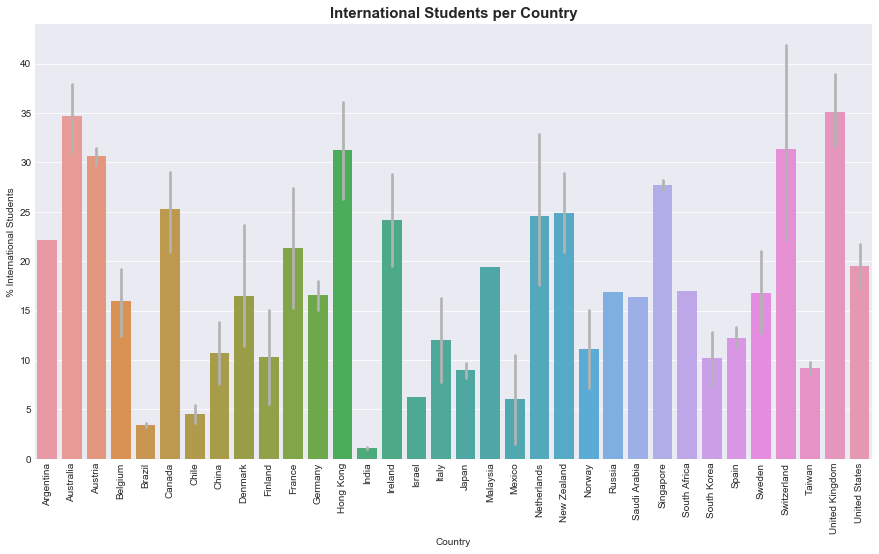

In [266]:
bars("International Students per Country", df_ranking.sort_values('Country'), 'Country', '% International Students')

#### d) Aggregating the data by region

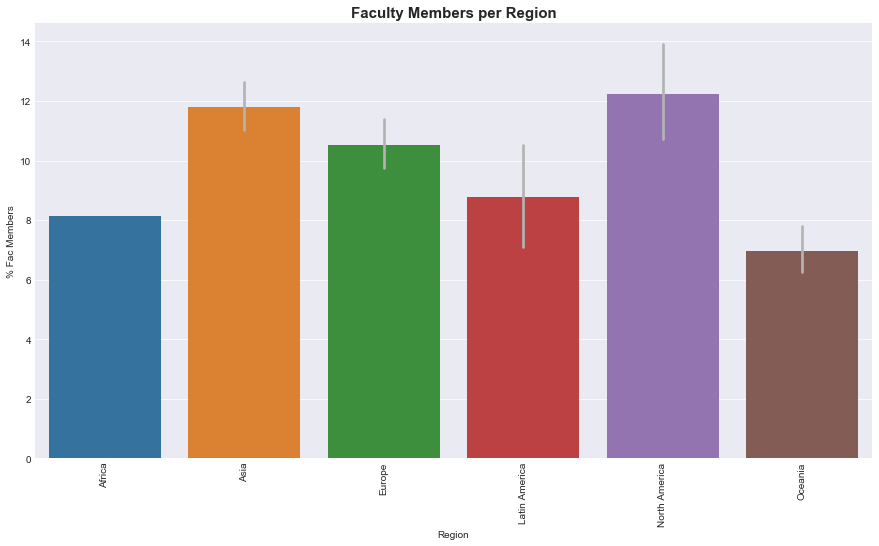

In [267]:
bars("Faculty Members per Region", df_ranking.sort_values('Region'), 'Region', '% Fac Members')

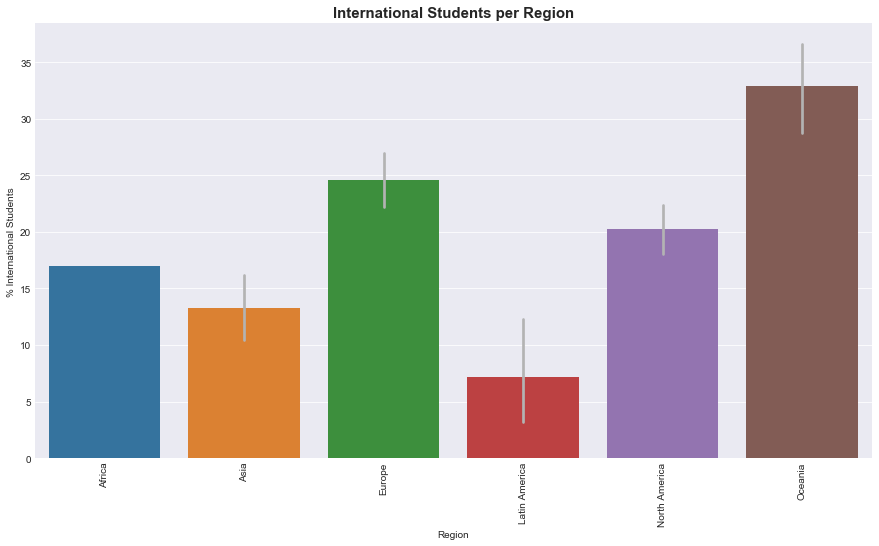

In [268]:
bars("International Students per Region", df_ranking.sort_values('Region'), 'Region', '% International Students')

### Question 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Using Postman, a API request was captured on the ranking, containing a json file with all the data.

In [269]:
times_r=requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
data=times_r.text

We decode the json file by keeping only the first 200 data items (each data item corresponds to an university, sorting according its ranking). Furthemore, we just extract the useful columns (name, location, rank, total number of students, percentage of international students and student/staff ratio). 

As we are asked to sort the universities according their ratio between faculty members and students, we're already converted the student/staff ratio to staff/student ratio and convert the ratio in percentage. 

In [270]:
df_times = pd.DataFrame(json.loads(data)['data'][:200],columns=['name','location','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio'])
df_times['stats_pc_intl_students'] = df_times['stats_pc_intl_students'].astype(str).str.replace('%','').astype(int)
df_times['stats_number_students'] = df_times['stats_number_students'].astype(str).str.replace(',','').astype(float)
df_times['stats_student_staff_ratio'] = 1/(df_times['stats_student_staff_ratio'].astype(float))
df_times.columns = ['University','Country','Rank','Total Students','% International Students','Fac Members/Students ratio']
df_times


,University,Country,Rank,Total Students,% International Students,Fac Members/Students ratio
0,University of Oxford,United Kingdom,1,20409.0,38,0.089286
1,University of Cambridge,United Kingdom,2,18389.0,35,0.091743
2,California Institute of Technology,United States,=3,2209.0,27,0.153846
3,Stanford University,United States,=3,15845.0,22,0.133333
4,Massachusetts Institute of Technology,United States,5,11177.0,34,0.114943
5,Harvard University,United States,6,20326.0,26,0.112360
6,Princeton University,United States,7,7955.0,24,0.120482
7,Imperial College London,United Kingdom,8,15857.0,55,0.087719
8,University of Chicago,United States,9,13525.0,25,0.161290
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,=10,19233.0,38,0.068493


We don't have the region information in the second website so we decide to use the information collected in the first one.

In [271]:
conv_to_cont = pd.DataFrame(data_QS.json()['data'],columns=['country','region']).drop_duplicates()
conv_to_cont.columns=['Country','Region'];
conv_to_cont.head()

,Country,Region
0,United States,North America
4,United Kingdom,Europe
9,Switzerland,Europe
10,Singapore,Asia
19,Australia,Oceania


Then, we merged the two dataframes on the country attribute.

In [272]:
df_times_final=pd.merge(df_times, conv_to_cont,how='left',left_on="Country",right_on="Country")


In [273]:
df_times_final[df_times_final.Region.isnull()]

,University,Country,Rank,Total Students,% International Students,Fac Members/Students ratio,Region
178,University of Luxembourg,Luxembourg,=179,4969.0,57,0.068493,NaN
193,Lomonosov Moscow State University,Russian Federation,194,29236.0,22,0.136986,NaN


As we can see below, two universities have no defined Region because the information about these countries was missing in the first ranking. We complete manually the missing information as just two universities are concerned and they won't appear on the barplot when we'll aggregate ranking by region otherwise.

In [274]:
df_times_final.at[178,'Region']='Europe'
df_times_final.at[193,'Region']='Europe'

Some informations are not explicitely present in our data as the number of international students and the total number of faculty members but we can infer them with the other columns according the following formulas :

Number of international students : *0.01 x Percentage of International Students x Total number of Students*

Total number of faculty members : *Total number of students x 0.01 x Ration between Faculty members and Students*

Nethertheless, we cannot infer the number of international faculty members but it is not essential for the results.

In [275]:
df_times_final['International Students'] = (df_times_final["Total Students"] * 0.01 * df_times_final["% International Students"]).astype(int)
df_times_final['Total Faculty Members'] = (df_times_final["Total Students"] * df_times_final["Fac Members/Students ratio"]).astype(int)
df_times_final['% Fac Members'] = df_times_final["Total Faculty Members"] / (df_times_final["Total Faculty Members"] + df_times_final["Total Students"]) * 100
df_times_final

,University,Country,Rank,Total Students,% International Students,Fac Members/Students ratio,Region,International Students,Total Faculty Members,% Fac Members
0,University of Oxford,United Kingdom,1,20409.0,38,0.089286,Europe,7755,1822,8.195763
1,University of Cambridge,United Kingdom,2,18389.0,35,0.091743,Europe,6436,1687,8.403068
2,California Institute of Technology,United States,=3,2209.0,27,0.153846,North America,596,339,13.304553
3,Stanford University,United States,=3,15845.0,22,0.133333,North America,3485,2112,11.761430
4,Massachusetts Institute of Technology,United States,5,11177.0,34,0.114943,North America,3800,1284,10.304149
5,Harvard University,United States,6,20326.0,26,0.112360,North America,5284,2283,10.097749
6,Princeton University,United States,7,7955.0,24,0.120482,North America,1909,958,10.748345
7,Imperial College London,United Kingdom,8,15857.0,55,0.087719,Europe,8721,1390,8.059373
8,University of Chicago,United States,9,13525.0,25,0.161290,North America,3381,2181,13.886413
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,=10,19233.0,38,0.068493,Europe,7308,1317,6.408759


#### a) Which are the best universities in term of ratio between faculty members and students ?

In [276]:
df_times_final.sort_values('% Fac Members', ascending=False)

,University,Country,Rank,Total Students,% International Students,Fac Members/Students ratio,Region,International Students,Total Faculty Members,% Fac Members
105,Vanderbilt University,United States,=105,12011.0,13,0.303030,North America,1561,3639,23.252396
109,University of Copenhagen,Denmark,=109,30395.0,14,0.243902,Europe,4255,7413,19.606961
12,Johns Hopkins University,United States,13,15498.0,24,0.232558,North America,3719,3604,18.867134
11,Yale University,United States,12,12155.0,21,0.232558,North America,2552,2826,18.863894
153,University of Rochester,United States,=153,9636.0,29,0.232558,North America,2794,2240,18.861570
97,Emory University,United States,98,12649.0,19,0.227273,North America,2403,2874,18.514462
16,Duke University,United States,17,15256.0,22,0.222222,North America,3356,3390,18.180843
114,École Polytechnique,France,115,2799.0,36,0.196078,Europe,1007,548,16.372871
183,Scuola Normale Superiore di Pisa,Italy,184,515.0,7,0.192308,Europe,36,99,16.123779
185,University of Miami,United States,186,15860.0,16,0.169492,North America,2537,2688,14.492129


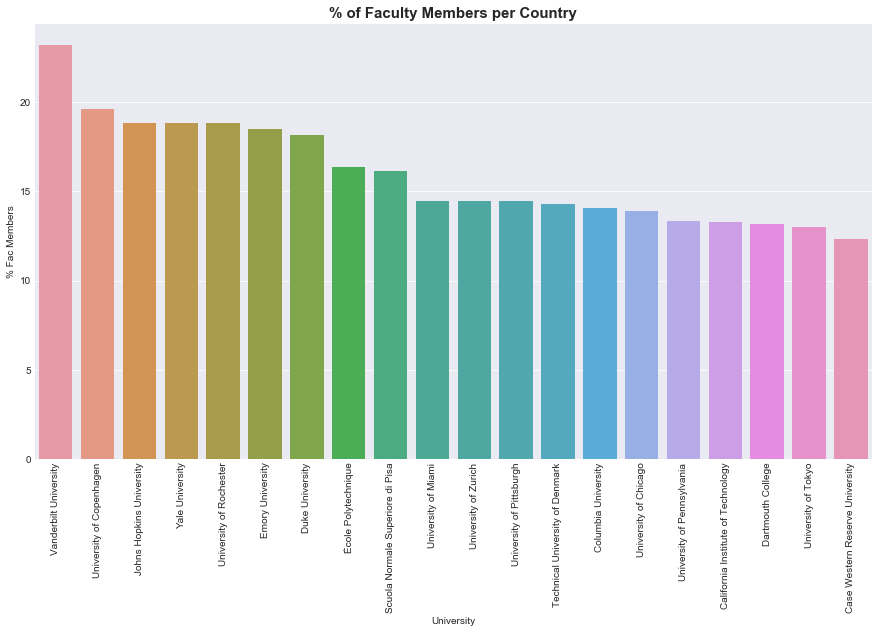

In [277]:
bars("% of Faculty Members per Country", df_times_final.sort_values('% Fac Members', ascending=False)[:20], 'University', '% Fac Members')

#### b) Which are the best universities in term of ratio of international students?

In [278]:
df_times_final.sort_values('% International Students', ascending=False)

,University,Country,Rank,Total Students,% International Students,Fac Members/Students ratio,Region,International Students,Total Faculty Members,% Fac Members
24,London School of Economics and Political Science,United Kingdom,=25,10065.0,71,0.081967,Europe,7146,825,7.575758
178,University of Luxembourg,Luxembourg,=179,4969.0,57,0.068493,Europe,2832,340,6.404219
37,École Polytechnique Fédérale de Lausanne,Switzerland,=38,9928.0,55,0.089286,Europe,5460,886,8.193083
7,Imperial College London,United Kingdom,8,15857.0,55,0.087719,Europe,8721,1390,8.059373
102,Maastricht University,Netherlands,103,16727.0,50,0.055556,Europe,8363,929,5.261667
15,University College London,United Kingdom,16,30304.0,49,0.095238,Europe,14848,2886,8.695390
143,University of St Andrews,United Kingdom,=143,9005.0,48,0.076923,Europe,4322,692,7.136228
23,Carnegie Mellon University,United States,24,12676.0,45,0.074074,North America,5704,938,6.889966
120,Queen Mary University of London,United Kingdom,121,15405.0,45,0.075188,Europe,6932,1158,6.991487
39,University of Hong Kong,Hong Kong,40,18364.0,42,0.055556,Asia,7712,1020,5.262072


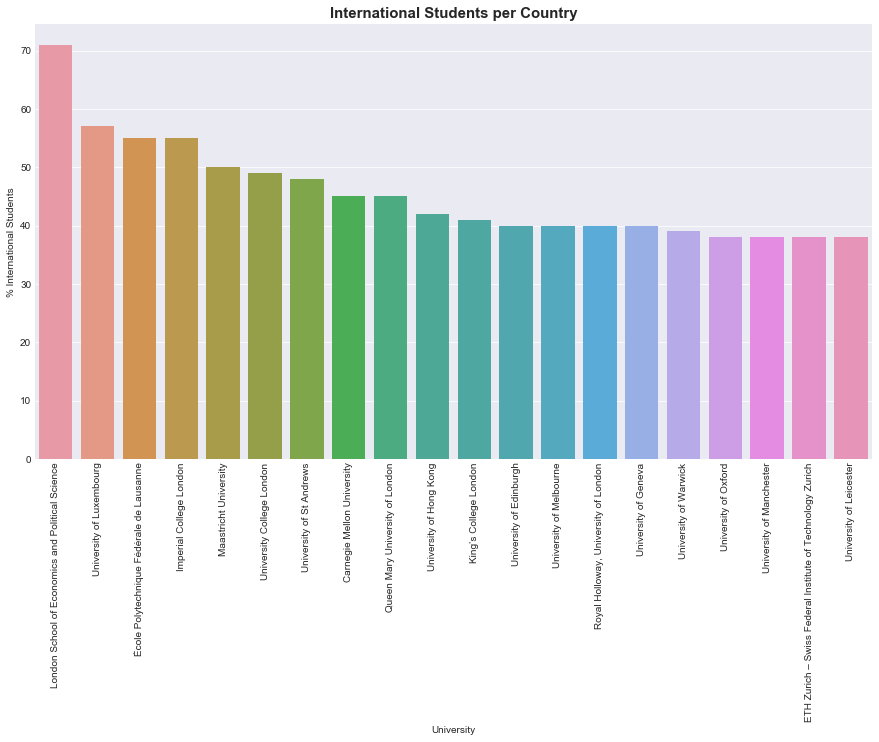

In [279]:
bars("International Students per Country", df_times_final.sort_values('% International Students', ascending=False)[:20], 'University', '% International Students')

#### c) Aggregating the data by country

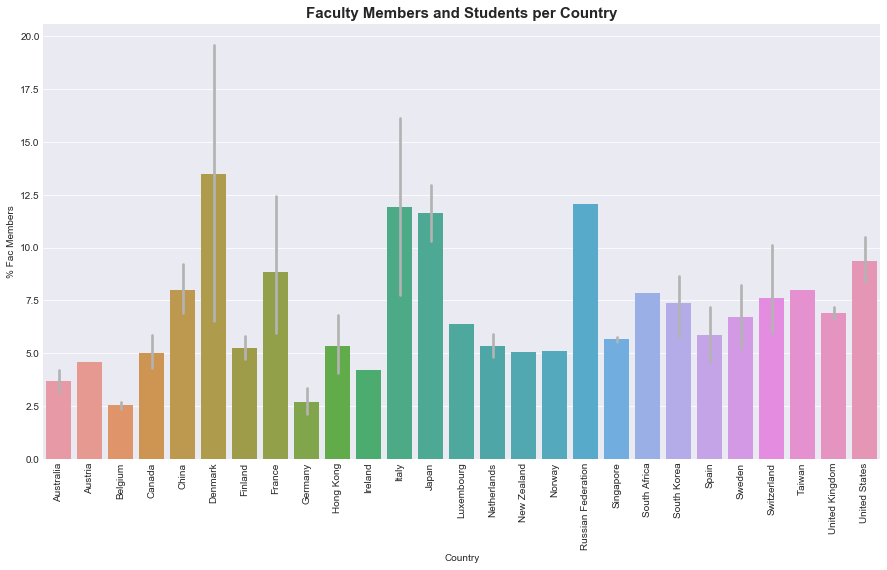

In [280]:
bars("Faculty Members and Students per Country", df_times_final.sort_values('Country'), 'Country', '% Fac Members')

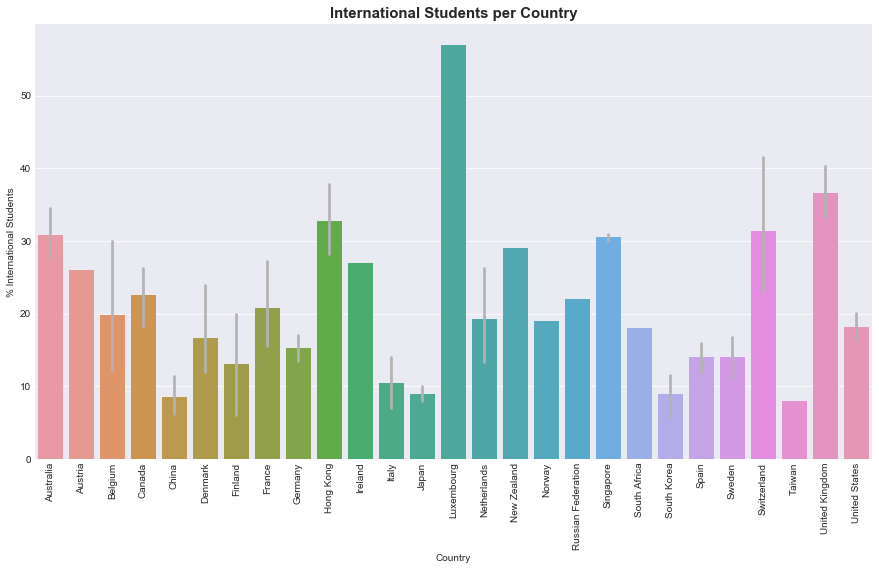

In [281]:
bars("International Students per Country", df_times_final.sort_values('Country'), 'Country', '% International Students')

#### d) Aggregating the data by region

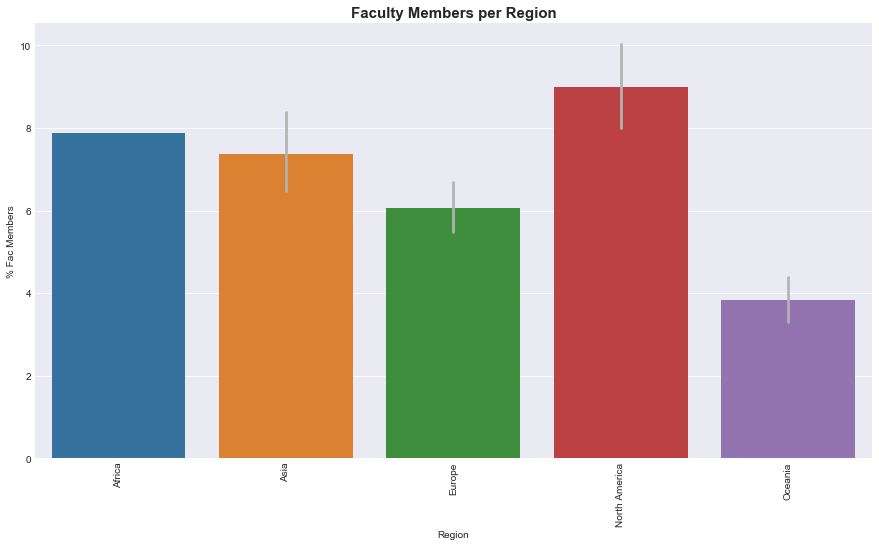

In [282]:
bars("Faculty Members per Region", df_times_final.sort_values('Region'), 'Region', '% Fac Members')


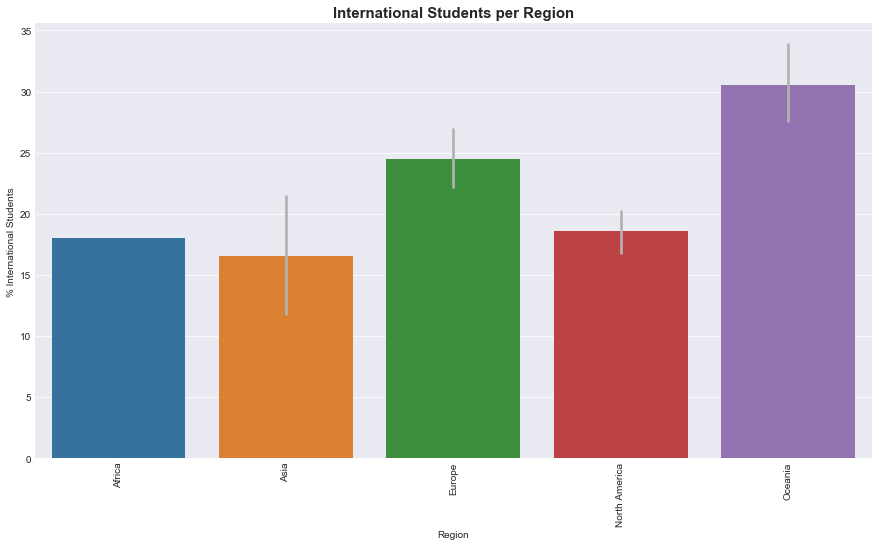

In [283]:
bars("International Students per Region", df_times_final.sort_values('Region'), 'Region', '% International Students')

### Question 3


Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

First, we try a naive inner (by default) merge on the "University" columns and we obtain 105 rows, meaning only about half of the university names matched.

In [284]:
df_ranking.merge(df_times_final,on="University").shape[0]

105

So we take a closer look at the list of names for each ranking :

In [285]:
pd.DataFrame({"qs":df_ranking["University"],"times":df_times_final["University"]})

,qs,times
0,Massachusetts Institute of Technology (MIT),University of Oxford
1,Stanford University,University of Cambridge
2,Harvard University,California Institute of Technology
3,California Institute of Technology (Caltech),Stanford University
4,University of Cambridge,Massachusetts Institute of Technology
5,University of Oxford,Harvard University
6,UCL (University College London),Princeton University
7,Imperial College London,Imperial College London
8,University of Chicago,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...,ETH Zurich – Swiss Federal Institute of Techno...


We notice a lot of universities have their initials in parenthesis after their name in the QS ranking, so we start by removing those parenthesis.

In [293]:
df_ranking["University"] = df_ranking["University"].str.replace(r"\(.*\)","").str.strip()

In [295]:
df_ranking.merge(df_times_final,on="University").shape[0]

115

We obtain a slight improvement of 10 more matches.

## TODO

In [288]:
df_ranking[df_ranking["University"].str.contains("Zurich")].University[9]

'ETH Zurich - Swiss Federal Institute of Technology'

In [289]:
df_times_final[df_times_final["University"].str.contains("Zurich")].University[9]

'ETH Zurich – Swiss Federal Institute of Technology Zurich'

In [290]:
df_ranking.merge(df_times_final.drop(["Country","Region"],axis=1),on="University",suffixes=("_qs","_times"))[["University","Rank_qs","Rank_times","Country","Region"]]

,University,Rank_qs,Rank_times,Country,Region
0,Stanford University,2,=3,United States,North America
1,Harvard University,3,6,United States,North America
2,University of Cambridge,5,2,United Kingdom,Europe
3,University of Oxford,6,1,United Kingdom,Europe
4,Imperial College London,8,8,United Kingdom,Europe
5,University of Chicago,9,9,United States,North America
6,Princeton University,13,7,United States,North America
7,Cornell University,14,19,United States,North America
8,Yale University,16,12,United States,North America
9,Johns Hopkins University,17,13,United States,North America


In [291]:
from difflib import SequenceMatcher

name_map = {}
for name1 in df_ranking["University"]:
    max_ratio = 0
    match = ""
    for name2 in df_times_final["University"]:
        ratio = SequenceMatcher(None,name1,name2).ratio()
        if ratio>max_ratio:
            max_ratio = ratio
            match = name2
    if (len(match) > 1):
        name_map[name1] = match
    

print(name_map)

{'Massachusetts Institute of Technology ': 'Massachusetts Institute of Technology', 'Stanford University': 'Stanford University', 'Harvard University': 'Harvard University', 'California Institute of Technology ': 'California Institute of Technology', 'University of Cambridge': 'University of Cambridge', 'University of Oxford': 'University of Oxford', 'UCL ': 'KU Leuven', 'Imperial College London': 'Imperial College London', 'University of Chicago': 'University of Chicago', 'ETH Zurich - Swiss Federal Institute of Technology': 'ETH Zurich – Swiss Federal Institute of Technology Zurich', 'Nanyang Technological University, Singapore ': 'Nanyang Technological University, Singapore', 'Ecole Polytechnique Fédérale de Lausanne ': 'École Polytechnique Fédérale de Lausanne', 'Princeton University': 'Princeton University', 'Cornell University': 'Cornell University', 'National University of Singapore ': 'National University of Singapore', 'Yale University': 'Yale University', 'Johns Hopkins Unive

### Question 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.